In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

## Data

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-12'),
    val_days=5,
    split='train'
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-12'),
    val_days=5,
    split='valid',
    mins=ds_train.mins,
    maxs=ds_train.maxs
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid))

In [8]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, sampler=sampler_valid)

In [9]:
len(ds_train), len(dl_train)

(20988, 656)

## Networks

In [135]:
gen = Generator(
    nres=3, nf_in=1, nf=32, relu_out=False, use_noise=True, spectral_norm=True
).to(device)

In [136]:
disc = Discriminator(
    [16, 16, 32, 32, 64, 64], sigmoid=False, spectral_norm=True
).to(device)

Size after convolutions 256


In [137]:
gen = gen.apply(weights_init_normal)
disc = disc.apply(weights_init_normal)

In [179]:
betas = (0.5, 0.999)
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=5e-6, betas=betas)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=5e-5, betas=betas)

In [172]:
X, y = next(iter(dl_train))

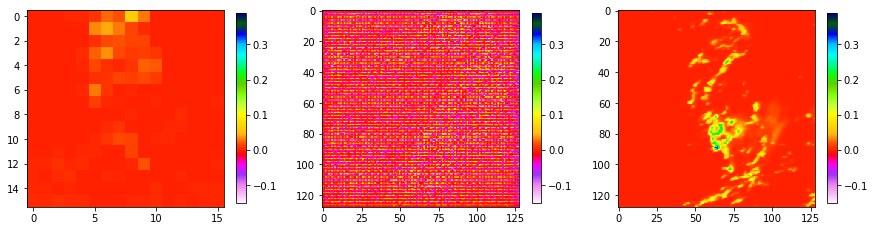

In [173]:
plot_sample(X, y, gen, 0)

In [174]:
X_sample, y_sample = X, y

## Pretrain

In [175]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [176]:
trainer = Trainer(gen, optimizer, criterion, dl_train, dl_valid)

In [102]:
trainer.fit(4)

KeyboardInterrupt: 

In [177]:
# torch.save(gen.state_dict(), f'gen_pretrained.pt')
gen.load_state_dict(torch.load('gen_pretrained.pt'))

<All keys matched successfully>

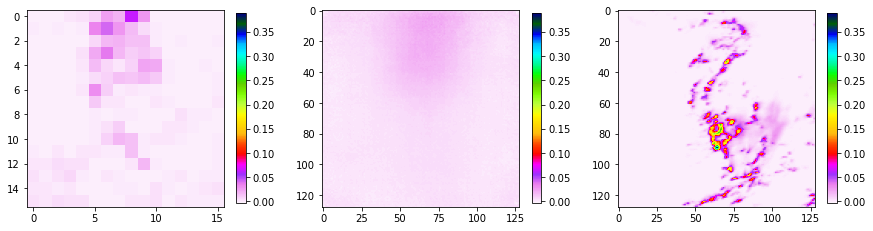

In [178]:
plot_sample(X, y, gen, 0)

## Trainer

In [180]:
trainer = GANTrainer(
    gen, disc, gen_optimizer, disc_optimizer, dl_train, gen_repeats=4, l_loss='l1', 
    dloss_type='Wasserstein',
    l_lambda=5, plot=True, plotting_sample=(X_sample, y_sample)
)

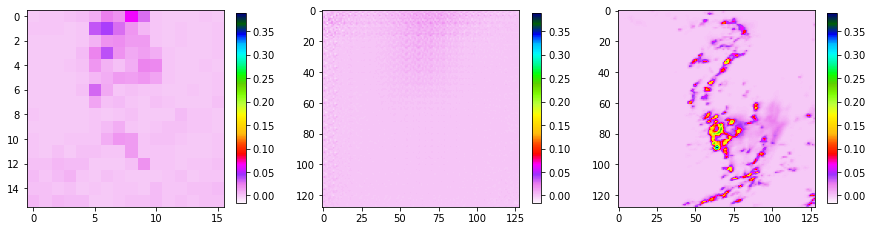

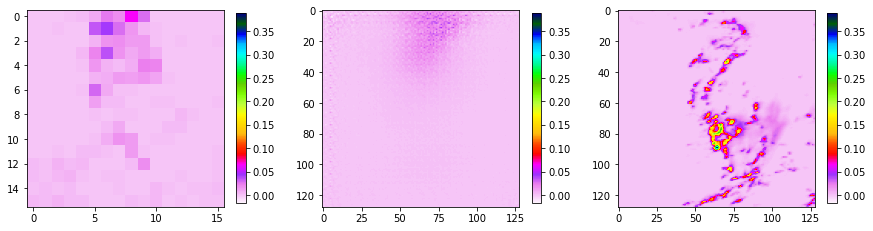

In [181]:
trainer.fit(2)

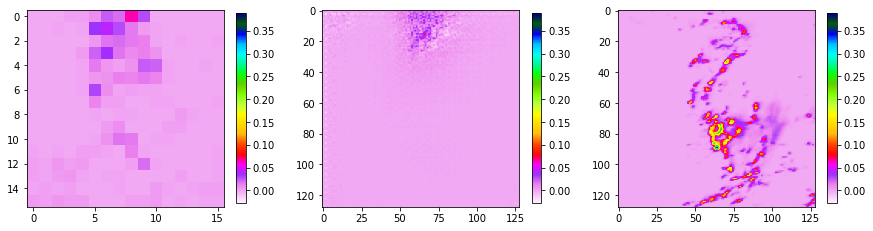

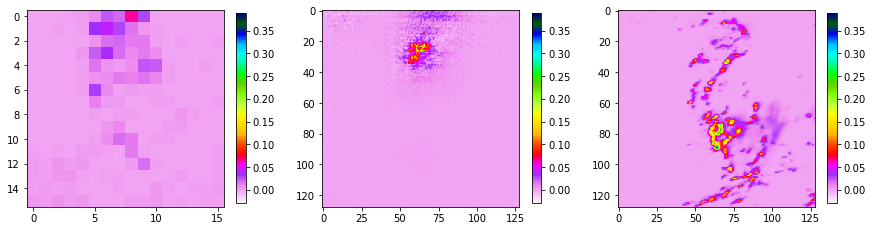

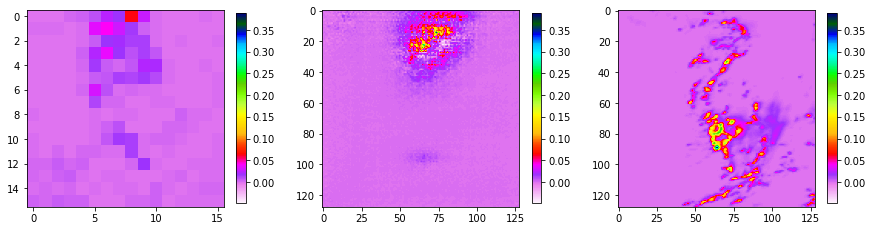

KeyboardInterrupt: 

In [182]:
trainer.fit(5)

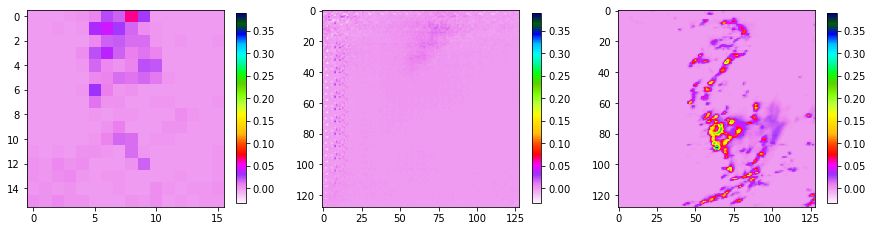

In [ ]:
trainer.fit(5)

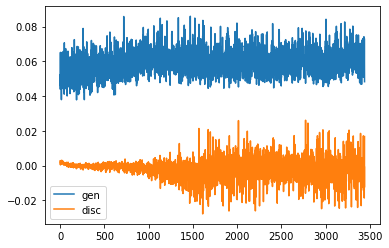

In [183]:
plt.plot(trainer.train_gen_losses, label='gen')
plt.plot(trainer.train_disc_losses, label='disc')
plt.legend()

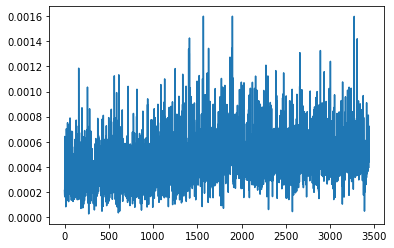

In [184]:
plt.plot(trainer.train_mse)

In [185]:
# What is the discriminator doing?

(array([18.,  6.,  2.,  0.,  0.,  1.,  2.,  1.,  0.,  2.]),
 array([-0.02943197, -0.02680269, -0.02417341, -0.02154413, -0.01891485,
        -0.01628557, -0.01365629, -0.01102701, -0.00839773, -0.00576846,
        -0.00313918], dtype=float32),
 <BarContainer object of 10 artists>)

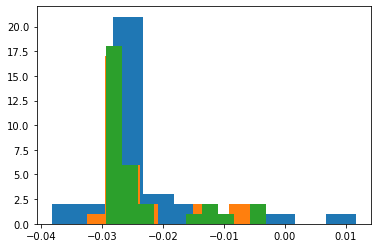

In [186]:
plt.hist(trainer.disc_preds_real[-1])
plt.hist(trainer.disc_preds_fake[-1])
plt.hist(trainer.gen_preds_fake[-1])

In [187]:
N = 20
disc_preds_real = np.convolve([x.mean() for x in trainer.disc_preds_real], np.ones(N)/N, mode='valid')
disc_preds_fake = np.convolve([x.mean() for x in trainer.disc_preds_fake], np.ones(N)/N, mode='valid')
gen_preds_fake = np.convolve([x.mean() for x in trainer.gen_preds_fake][::4], np.ones(N)/N, mode='valid')

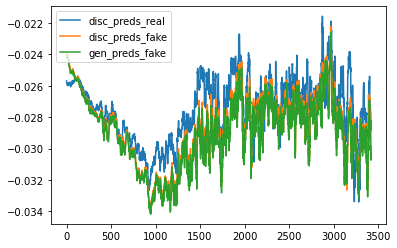

In [188]:
plt.plot(disc_preds_real, label='disc_preds_real')
plt.plot(disc_preds_fake, label='disc_preds_fake')
plt.plot(gen_preds_fake, label='gen_preds_fake')
plt.legend()

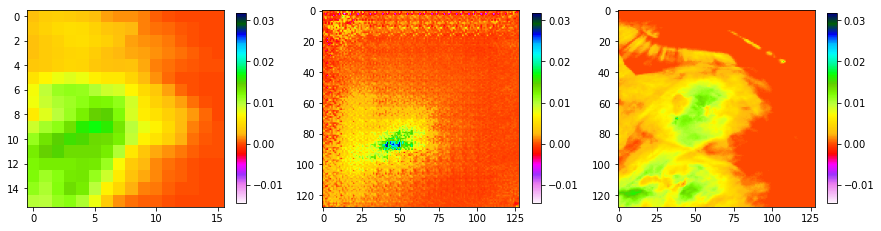

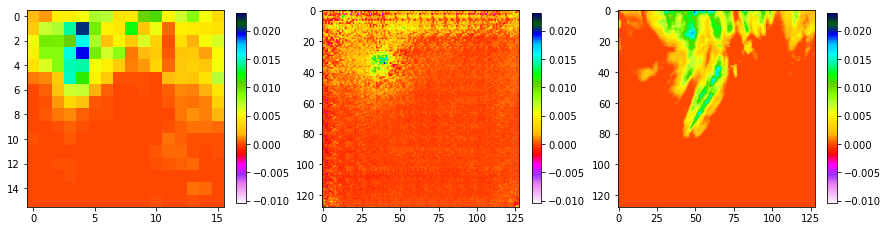

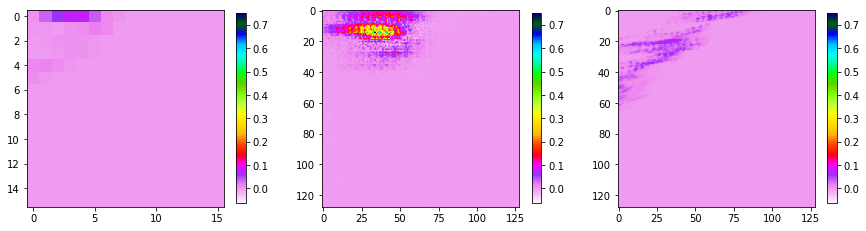

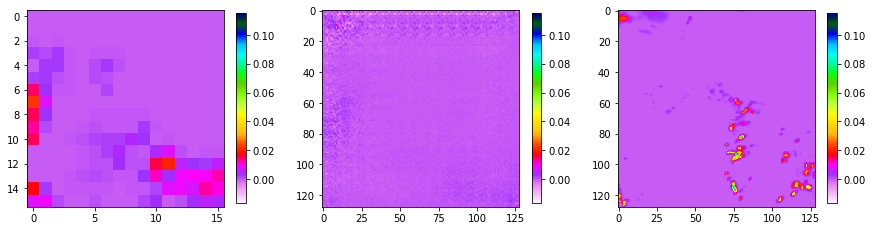

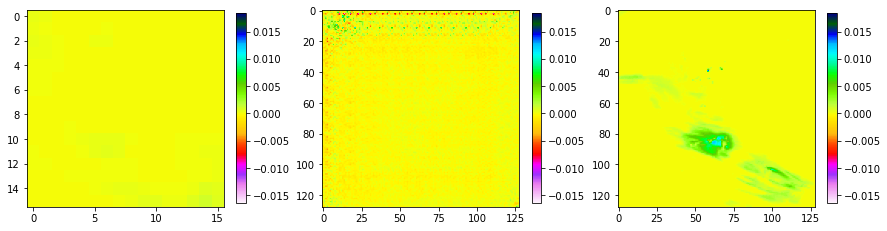

In [189]:
X, y = next(iter(dl_train))
for i in range(5):
    plot_sample(X, y, gen, i)

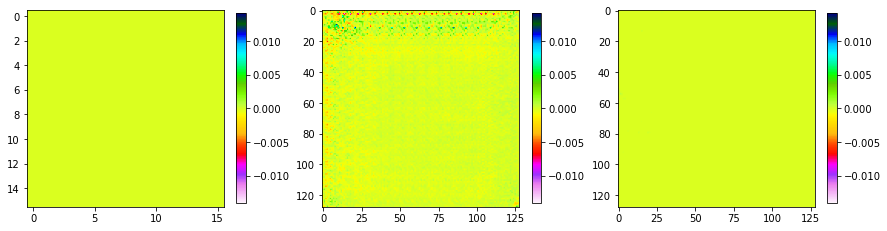

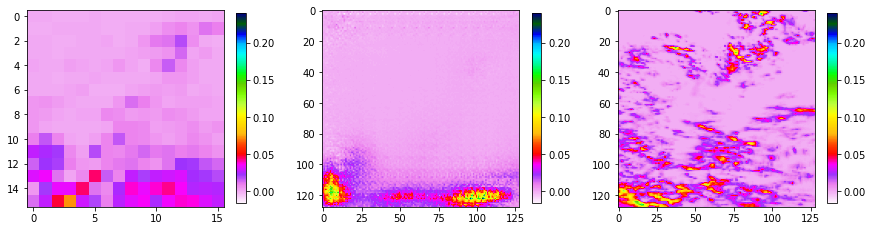

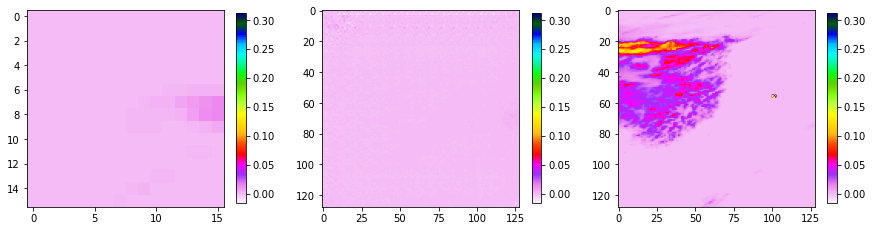

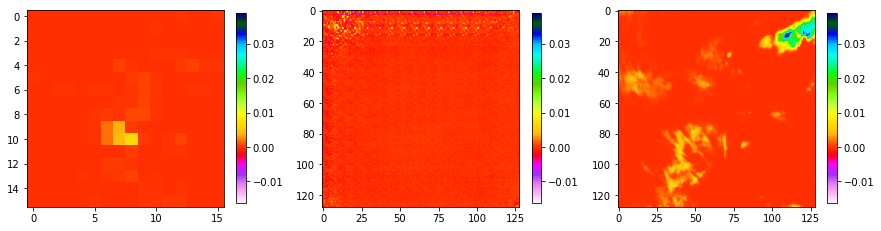

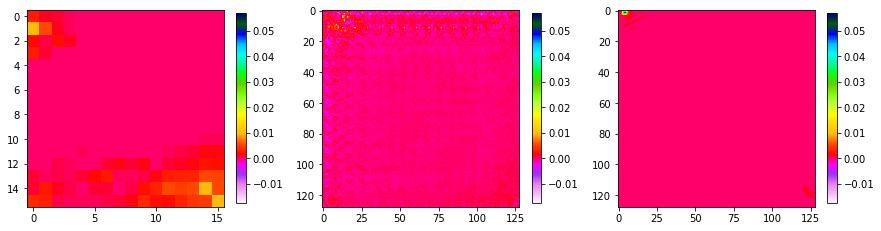

In [190]:
X, y = next(iter(dl_valid))
for i in range(5):
    plot_sample(X, y, gen, i)